## Class 9 Agenda:
  * **Feature Decomposition and Dimensionality Reduction: PCA**
  * **Regularization: Lasso Regression (L1 regularization for Logistic Regression)**
  * **Regularization: Ridge Regression (L2 regularization for Logistic Regression)**
  * **Regularization: Elastic Net Regression (L1 and L2 combined regularization for Logistic Regression)**

Today we talk about what happens when we have lots of predictor variables (columns/features), and are trying to both generate accurate models, and reduce the number of columns we use to predict/explain what is going on in our dataset.

We may need to do this for a variety of reasons.

In many instances, the number of columns you have in your data can be much larger than the number of samples (examples/rows) you have. One unfortunate result of this can be that we **overfit** our models (many different combinations of the columns in our data can generate the same training results). We need a systematic way to reduce the number of columns we use in our models to just those columns that are the most important for our prediction.

**How can we tell which columns are the most important, and how can we reduce or recombine them in such a way that we just keep/use the most important ones?**

That's the topic of today's lesson.

In general, not all of the columns in our dataset may be critical for predicting a given outcome variable because:

1. Several columns may be highly correlated with each other (provide redundant information) and with the outcome variable.
2. Columns may not be correlated at all with the outcome attribute (have no "predictive ability" in terms of what you're trying to predict).

The two strategies for dealing with both of these cases are called **Dimensionality Reduction** and **Regularization.** Both strategies can be used for supervised classification/regression problems, as well as for unsupervised learning and clustering.

By the end of this lesson you will be able to:

  * use PCA to reduce the size of a given dataset's features to a strictly smaller number of features
  * understand how to interpret the eigenvalues and variance explained by a certain number of PCs after performing PCA
  * use Lasso/L1 regularization for both feature selection and general regression/classification problems
  * use Ridge/L2 regularization for regression and classification problems
  * explain the difference between L1/L2 regularization

In [1]:
from __future__ import print_function, division, absolute_import  # Python 2/3

In [2]:
#data handling, model creation/evaluation
import pandas as pd
import numpy as np
import scipy.stats as stats

from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder, PolynomialFeatures, StandardScaler
from sklearn.linear_model import Lasso, Ridge, LinearRegression, LogisticRegression, ElasticNet
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
try:
    from sklearn.model_selection import cross_val_score, train_test_split
except ImportError:
    from sklearn.cross_validation import cross_val_score, train_test_split
    
# visualization
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

We are going to use the [Boston Housing Dataset](http://archive.ics.uci.edu/ml/datasets/Housing) from the UCI repo to explore both Feature Decomposition/Dimensionality Reduction and Regularization.

Here's the dataset schema:

  1. **crime:** per capita crime rate by town
  2. **zone:** proportion of residential land zoned for lots over 25,000 sq.ft.
  3. **industry:** proportion of non-retail business acres per town
  4. **charles:** Charles River dummy variable (1 if tract bounds river; 0 otherwise)
  5. **no:** nitric oxides concentration (parts per 10 million)
  6. **rooms:** average number of rooms per dwelling
  7. **age:** proportion of owner-occupied units built prior to 1940
  8. **distance:** weighted distances to five Boston employment centres
  9. **radial:** index of accessibility to radial highways
  10. **tax:** full-value property-tax rate per 10K dollars
  11. **pupil:** pupil-teacher ratio by town
  12. **aam:** $1000(aam - 0.63)^2$ where aam is the proportion of african americans by town
  13. **lower:** percentage lower income status of the population
  14. **med_price:** Median value of owner-occupied homes in $1000's
  
Let's load the data in:

In [3]:
housing_columns = ["crime","zone","industry","charles","no","rooms","age",
                   "distance","radial","tax","pupil","aam","lower","med_price"]
housing_features = housing_columns[:-1]
housing_target = housing_columns[-1]
housing_data = pd.read_csv("../data/boston_housing.csv",names=housing_columns)
print(housing_columns)
print(housing_features)
print(housing_target)
print(housing_data.head())

['crime', 'zone', 'industry', 'charles', 'no', 'rooms', 'age', 'distance', 'radial', 'tax', 'pupil', 'aam', 'lower', 'med_price']
['crime', 'zone', 'industry', 'charles', 'no', 'rooms', 'age', 'distance', 'radial', 'tax', 'pupil', 'aam', 'lower']
med_price
     crime  zone  industry  charles     no  rooms   age  distance  radial  \
0  0.00632  18.0      2.31        0  0.538  6.575  65.2    4.0900       1   
1  0.02731   0.0      7.07        0  0.469  6.421  78.9    4.9671       2   
2  0.02729   0.0      7.07        0  0.469  7.185  61.1    4.9671       2   
3  0.03237   0.0      2.18        0  0.458  6.998  45.8    6.0622       3   
4  0.06905   0.0      2.18        0  0.458  7.147  54.2    6.0622       3   

     tax  pupil     aam  lower  med_price  
0  296.0   15.3  396.90   4.98       24.0  
1  242.0   17.8  396.90   9.14       21.6  
2  242.0   17.8  392.83   4.03       34.7  
3  222.0   18.7  394.63   2.94       33.4  
4  222.0   18.7  396.90   5.33       36.2  


And compute some basic stats per column:

In [4]:
housing_data.describe()   # this is an all-numerical dataset

,crime,zone,industry,charles,no,rooms,age,distance,radial,tax,pupil,aam,lower,med_price
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000
75%,3.677082,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


In [5]:
housing_data.head()

,crime,zone,industry,charles,no,rooms,age,distance,radial,tax,pupil,aam,lower,med_price
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


And let's look at the correlation matrix:

,crime,zone,industry,charles,no,rooms,age,distance,radial,tax,pupil,aam,lower,med_price
crime,1.000000,-0.200469,0.406583,-0.055892,0.420972,-0.219247,0.352734,-0.379670,0.625505,0.582764,0.289946,-0.385064,0.455621,-0.388305
zone,-0.200469,1.000000,-0.533828,-0.042697,-0.516604,0.311991,-0.569537,0.664408,-0.311948,-0.314563,-0.391679,0.175520,-0.412995,0.360445
industry,0.406583,-0.533828,1.000000,0.062938,0.763651,-0.391676,0.644779,-0.708027,0.595129,0.720760,0.383248,-0.356977,0.603800,-0.483725
charles,-0.055892,-0.042697,0.062938,1.000000,0.091203,0.091251,0.086518,-0.099176,-0.007368,-0.035587,-0.121515,0.048788,-0.053929,0.175260
no,0.420972,-0.516604,0.763651,0.091203,1.000000,-0.302188,0.731470,-0.769230,0.611441,0.668023,0.188933,-0.380051,0.590879,-0.427321
rooms,-0.219247,0.311991,-0.391676,0.091251,-0.302188,1.000000,-0.240265,0.205246,-0.209847,-0.292048,-0.355501,0.128069,-0.613808,0.695360
age,0.352734,-0.569537,0.644779,0.086518,0.731470,-0.240265,1.000000,-0.747881,0.456022,0.506456,0.261515,-0.273534,0.602339,-0.376955
distance,-0.379670,0.664408,-0.708027,-0.099176,-0.769230,0.205246,-0.747881,1.000000,-0.494588,-0.534432,-0.232471,0.291512,-0.496996,0.249929
radial,0.625505,-0.311948,0.595129,-0.007368,0.611441,-0.209847,0.456022,-0.494588,1.000000,0.910228,0.464741,-0.444413,0.488676,-0.381626
tax,0.582764,-0.314563,0.720760,-0.035587,0.668023,-0.292048,0.506456,-0.534432,0.910228,1.000000,0.460853,-0.441808,0.543993,-0.468536


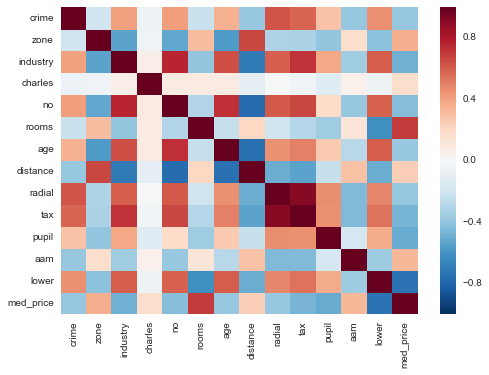

In [6]:
sns.heatmap(housing_data.corr())
housing_data.corr()

Let's also plot the histogram of median housing prices across the dataset. This is what we are going to try to predict initially.

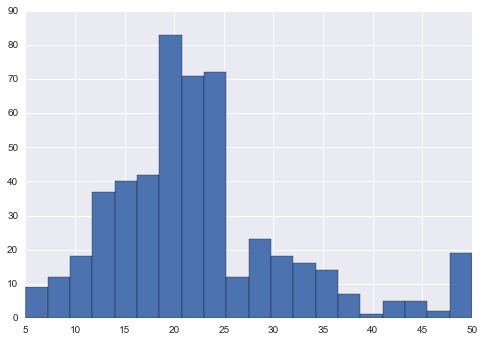

In [7]:
housing_data[housing_target].hist(bins=20)
# target feature: home prices in the thousands
# The x axis of the histogram is the housing price; what's the range of outcome that I should trust... there are not
# enough samples at $40000 price range... not enough data there

Let's try and build a linear regression model using this data, using 50-fold cross validation:

In [8]:
#standardize the features, to get actual interpretable coefficients for each feature
X = StandardScaler().fit_transform(housing_data[housing_features])
y = housing_data[housing_target]

lr = LinearRegression()

#must take absolute value because sklearn makes the errors negative - dont ask me why
mean_squared_errors = np.abs(cross_val_score(lr,X,y,cv=50,scoring='mean_squared_error'))
root_mean_squared_errors = np.sqrt(mean_squared_errors)
print(mean_squared_errors)
print(root_mean_squared_errors)
print("50-fold mean RMSE: ", np.mean(root_mean_squared_errors))
# When predicting a value for a home, predicted value is off by around $444. 

[  25.73133742    3.87358882    3.54550898    3.93269492    7.88499733
   17.81945726    5.56941131    4.15735961   23.60175806   11.91235579
    9.40496861    4.01757172    3.13562766   17.38032066   20.95329298
   54.80506488   30.58283317   22.56020799   37.24007991   21.96983546
   25.18506063   35.83006138   30.56900496   17.11408006   28.1159295
   27.53990163   18.89364184   15.51104517   11.57250918   17.54087755
   17.16840675    1.56096429    4.80845508    7.82196567   17.98142031
   60.74134364  452.04622034   30.00030653   20.98138077   45.33604786
   76.46862435   15.60603272   25.69717275    5.14904737   15.89572285
    3.24073349    7.95907182    7.39451077   15.59352626   21.65014882]
[  5.07260657   1.9681435    1.8829522    1.98310235   2.80802374
   4.2213099    2.35996002   2.03896042   4.85816406   3.45142808
   3.06675213   2.00438812   1.77077036   4.16897118   4.5774767
   7.4030443    5.53017479   4.74975873   6.10246507   4.68719911
   5.01847194   5.9858217  

So, we can expect to be off by ~4,000$ in our prediction if we use this model.

Now let's see what the coefficients of a model trained on all of the data look like:

In [9]:
coeffs = LinearRegression().fit(X,y).coef_
coeff_df = pd.DataFrame(list(zip(housing_features,np.abs(coeffs))),columns=["features","betas"])
coeff_df.sort_values("betas",ascending=False,inplace=True)
print(coeffs)
coeff_df
# These are the coefficients. The age coefficient is useless here.


[-0.92814606  1.08156863  0.1409      0.68173972 -2.05671827  2.67423017
  0.01946607 -3.10404426  2.66221764 -2.07678168 -2.06060666  0.84926842
 -3.74362713]


,features,betas
12,lower,3.743627
7,distance,3.104044
5,rooms,2.674230
8,radial,2.662218
9,tax,2.076782
10,pupil,2.060607
4,no,2.056718
1,zone,1.081569
0,crime,0.928146
11,aam,0.849268


Look at how the last couple features barely impact the linear regression. Let's see if we can't reduce the total number of columns we use without impacting the overall quality of the prediction.

We will try do this using **PCA**.

**PCA**, short for [**Principal Components Analysis**](https://en.wikipedia.org/wiki/Principal_component_analysis) is a method for transforming your initial features into a new feature space such that:
  * All of the new columns are uncorrelated with each other, but are linearly-blended versions of the original columns (features)
  * Each succesive column is less important in terms of how much of the variance (information) in the original data it explains. So, the first column is the "most important" (in a specific statistical sense) column, the 2nd column is "2nd most important" and so on.

We can generate a PCA-based transformation of our features. Let's see that in action:

In [10]:
pca = PCA()
transformed_pca_x = pca.fit_transform(housing_data[housing_features])
#create component indices
component_names = ["component_"+str(comp) for comp in range(1, len(pca.explained_variance_)+1)]

#generate new component dataframe
transformed_pca_x = pd.DataFrame(transformed_pca_x,columns=component_names)
print(housing_data[housing_features].head())
print(component_names)
print(pca.explained_variance_)
transformed_pca_x.head()

     crime  zone  industry  charles     no  rooms   age  distance  radial  \
0  0.00632  18.0      2.31        0  0.538  6.575  65.2    4.0900       1   
1  0.02731   0.0      7.07        0  0.469  6.421  78.9    4.9671       2   
2  0.02729   0.0      7.07        0  0.469  7.185  61.1    4.9671       2   
3  0.03237   0.0      2.18        0  0.458  6.998  45.8    6.0622       3   
4  0.06905   0.0      2.18        0  0.458  7.147  54.2    6.0622       3   

     tax  pupil     aam  lower  
0  296.0   15.3  396.90   4.98  
1  242.0   17.8  396.90   9.14  
2  242.0   17.8  392.83   4.03  
3  222.0   18.7  394.63   2.94  
4  222.0   18.7  396.90   5.33  
['component_1', 'component_2', 'component_3', 'component_4', 'component_5', 'component_6', 'component_7', 'component_8', 'component_9', 'component_10', 'component_11', 'component_12', 'component_13']
[  3.08288640e+04   6.23797763e+03   8.16746638e+02   2.66157793e+02
   4.97330463e+01   2.78217009e+01   1.60316401e+01   9.50848901e+00
 

,component_1,component_2,component_3,component_4,component_5,component_6,component_7,component_8,component_9,component_10,component_11,component_12,component_13
0,-119.818843,5.560056,-3.172693,5.291593,-1.818728,-6.312070,-1.032609,5.477971,-1.935498,0.329154,0.378374,0.071311,0.033545
1,-168.890155,-10.116209,-30.781887,1.296776,0.369680,-3.241821,-0.628651,0.915626,0.467686,-1.299810,0.048674,0.094734,-0.033150
2,-169.311707,-14.080532,-16.753628,-10.278399,-0.093409,-5.910068,1.718753,0.510026,0.414966,-0.910646,-0.467469,0.107257,-0.004509
3,-190.230642,-18.302463,-6.534195,-19.644921,1.513442,-6.959925,-1.971382,0.845947,1.063487,-0.964424,-0.276214,0.052466,0.043716
4,-190.133451,-16.097947,-13.158520,-14.178141,1.761005,-5.760987,-3.059650,1.032843,1.062885,-1.123178,-0.538077,0.055400,0.035538


Once PCA is performed on a given dataset, we get several pieces of information:

  * We get a PCA decomposition of the original features into PCA components, into what is called a component matrix. This matrix tells us how to generate the new components (by blending the original features/columns) and is ordered from most-important to least important
  * We get what are called the **eigenvectors** of each newly-generated component (column), which tells us how important that column is in terms of the amount of the "information" in the original dataset it explains. From the eigenvectors, we can compute the total amount of variance explained per-component as a fraction of the total amount of variance in the original dataset.

In general, **PCA is a useful method for reducing your data to a smaller dimensional representation that you can look at, not necessarily that you can then successfully predict from.**

Let's take a look at both the component matrix and the importance of each PCA dimension.

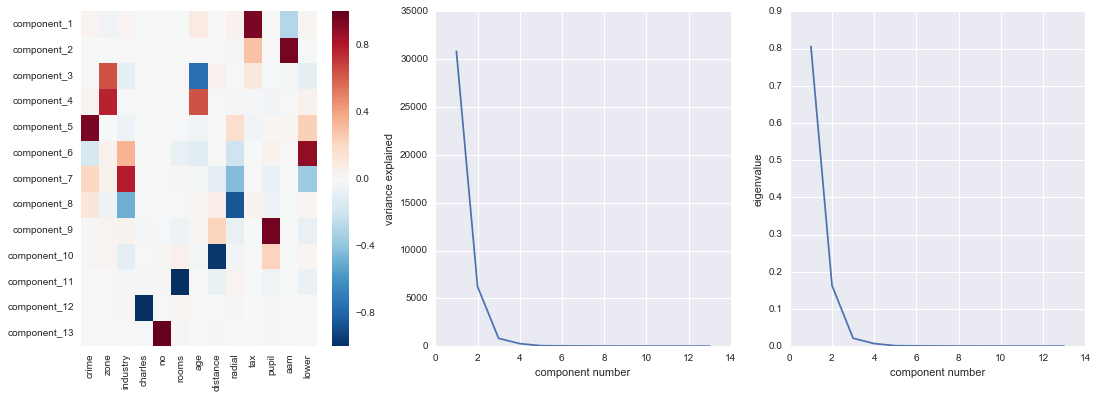

In [11]:
#generate component loadings on original features
component_matrix = pd.DataFrame(pca.components_,index=component_names,columns = housing_features)
#add additional columns to describe what
component_matrix["explained_variance_ratio"] = pca.explained_variance_ratio_
component_matrix["eigenvalue"] = pca.explained_variance_
figure = sns.plt.figure(figsize=(18,6))
#add 3 subplots one at a time

#first the component matrix
figure.add_subplot(131)
sns.heatmap(component_matrix.ix[:,:-2])

#then the eigenvalues
figure.add_subplot(132)
sns.plt.plot(range(1,component_matrix.shape[0]+1), component_matrix.eigenvalue)
sns.plt.xlabel("component number")
sns.plt.ylabel("variance explained")

#then the explained variance ratio
figure.add_subplot(133)
sns.plt.plot(range(1,component_matrix.shape[0]+1), component_matrix.explained_variance_ratio)
sns.plt.xlabel("component number")
sns.plt.ylabel("eigenvalue")

In essence, is fundamentally a linear method for projecting the original data onto a smaller-dimensional space (fewer columns) that keeps as much of the variance (distribution) of the original data as possible. What fraction of the original variance is explained by using just the first two PCA components?

In [12]:
component_matrix.explained_variance_ratio.cumsum()

component_1     0.805823
component_2     0.968875
component_3     0.990224
component_4     0.997181
component_5     0.998481
component_6     0.999208
component_7     0.999627
component_8     0.999875
component_9     0.999961
component_10    0.999992
component_11    0.999998
component_12    1.000000
component_13    1.000000
Name: explained_variance_ratio, dtype: float64

So it looks like just the first 2 components explain ~97% of the total variance in the dataset. Let's try to use just those 2 components to predict house price and see if it gives us comparable performance:

In [13]:
mean_squared_errors = np.abs(cross_val_score(lr,transformed_pca_x.ix[:,:2],y,cv=50,scoring='mean_squared_error'))
#apply square root to each fold
root_mean_squared_errors = np.sqrt(mean_squared_errors)
print("50-fold mean RMSE: ", np.mean(root_mean_squared_errors))
print("50-fold std RMSE: ", np.std(root_mean_squared_errors))
#Recall that we intially/originally had:   50-fold mean RMSE:  4.44466151015

50-fold mean RMSE:  7.07317986785
50-fold std RMSE:  4.17602902835


So it looks like this gives us pretty terrible performance.

#### Exercise Time

* How many components do we need to keep until we achieve very similar performance?

In [14]:
# pass
lr = LinearRegression()
transformed_pca_x["housing_price_bin"] = pd.cut(housing_data[housing_target],5)
X=transformed_pca_x.iloc[:, :13]   #  we need to keep 13 components to achieve similar performance to
                                   # to what we had originally
mean_squared_errors = np.abs(cross_val_score(lr,X,y,cv=50,scoring='mean_squared_error'))
#apply square root to each fold
root_mean_squared_errors = np.sqrt(mean_squared_errors)
print("50-fold mean RMSE: ", np.mean(root_mean_squared_errors))
print("50-fold std RMSE: ", np.std(root_mean_squared_errors))

50-fold mean RMSE:  4.44466151015
50-fold std RMSE:  2.90964152404


Let's visualize all of the components and the binned housing price to see if they help at all in clearing up the relationship between the price and the bulk of the variance (information) in the data:

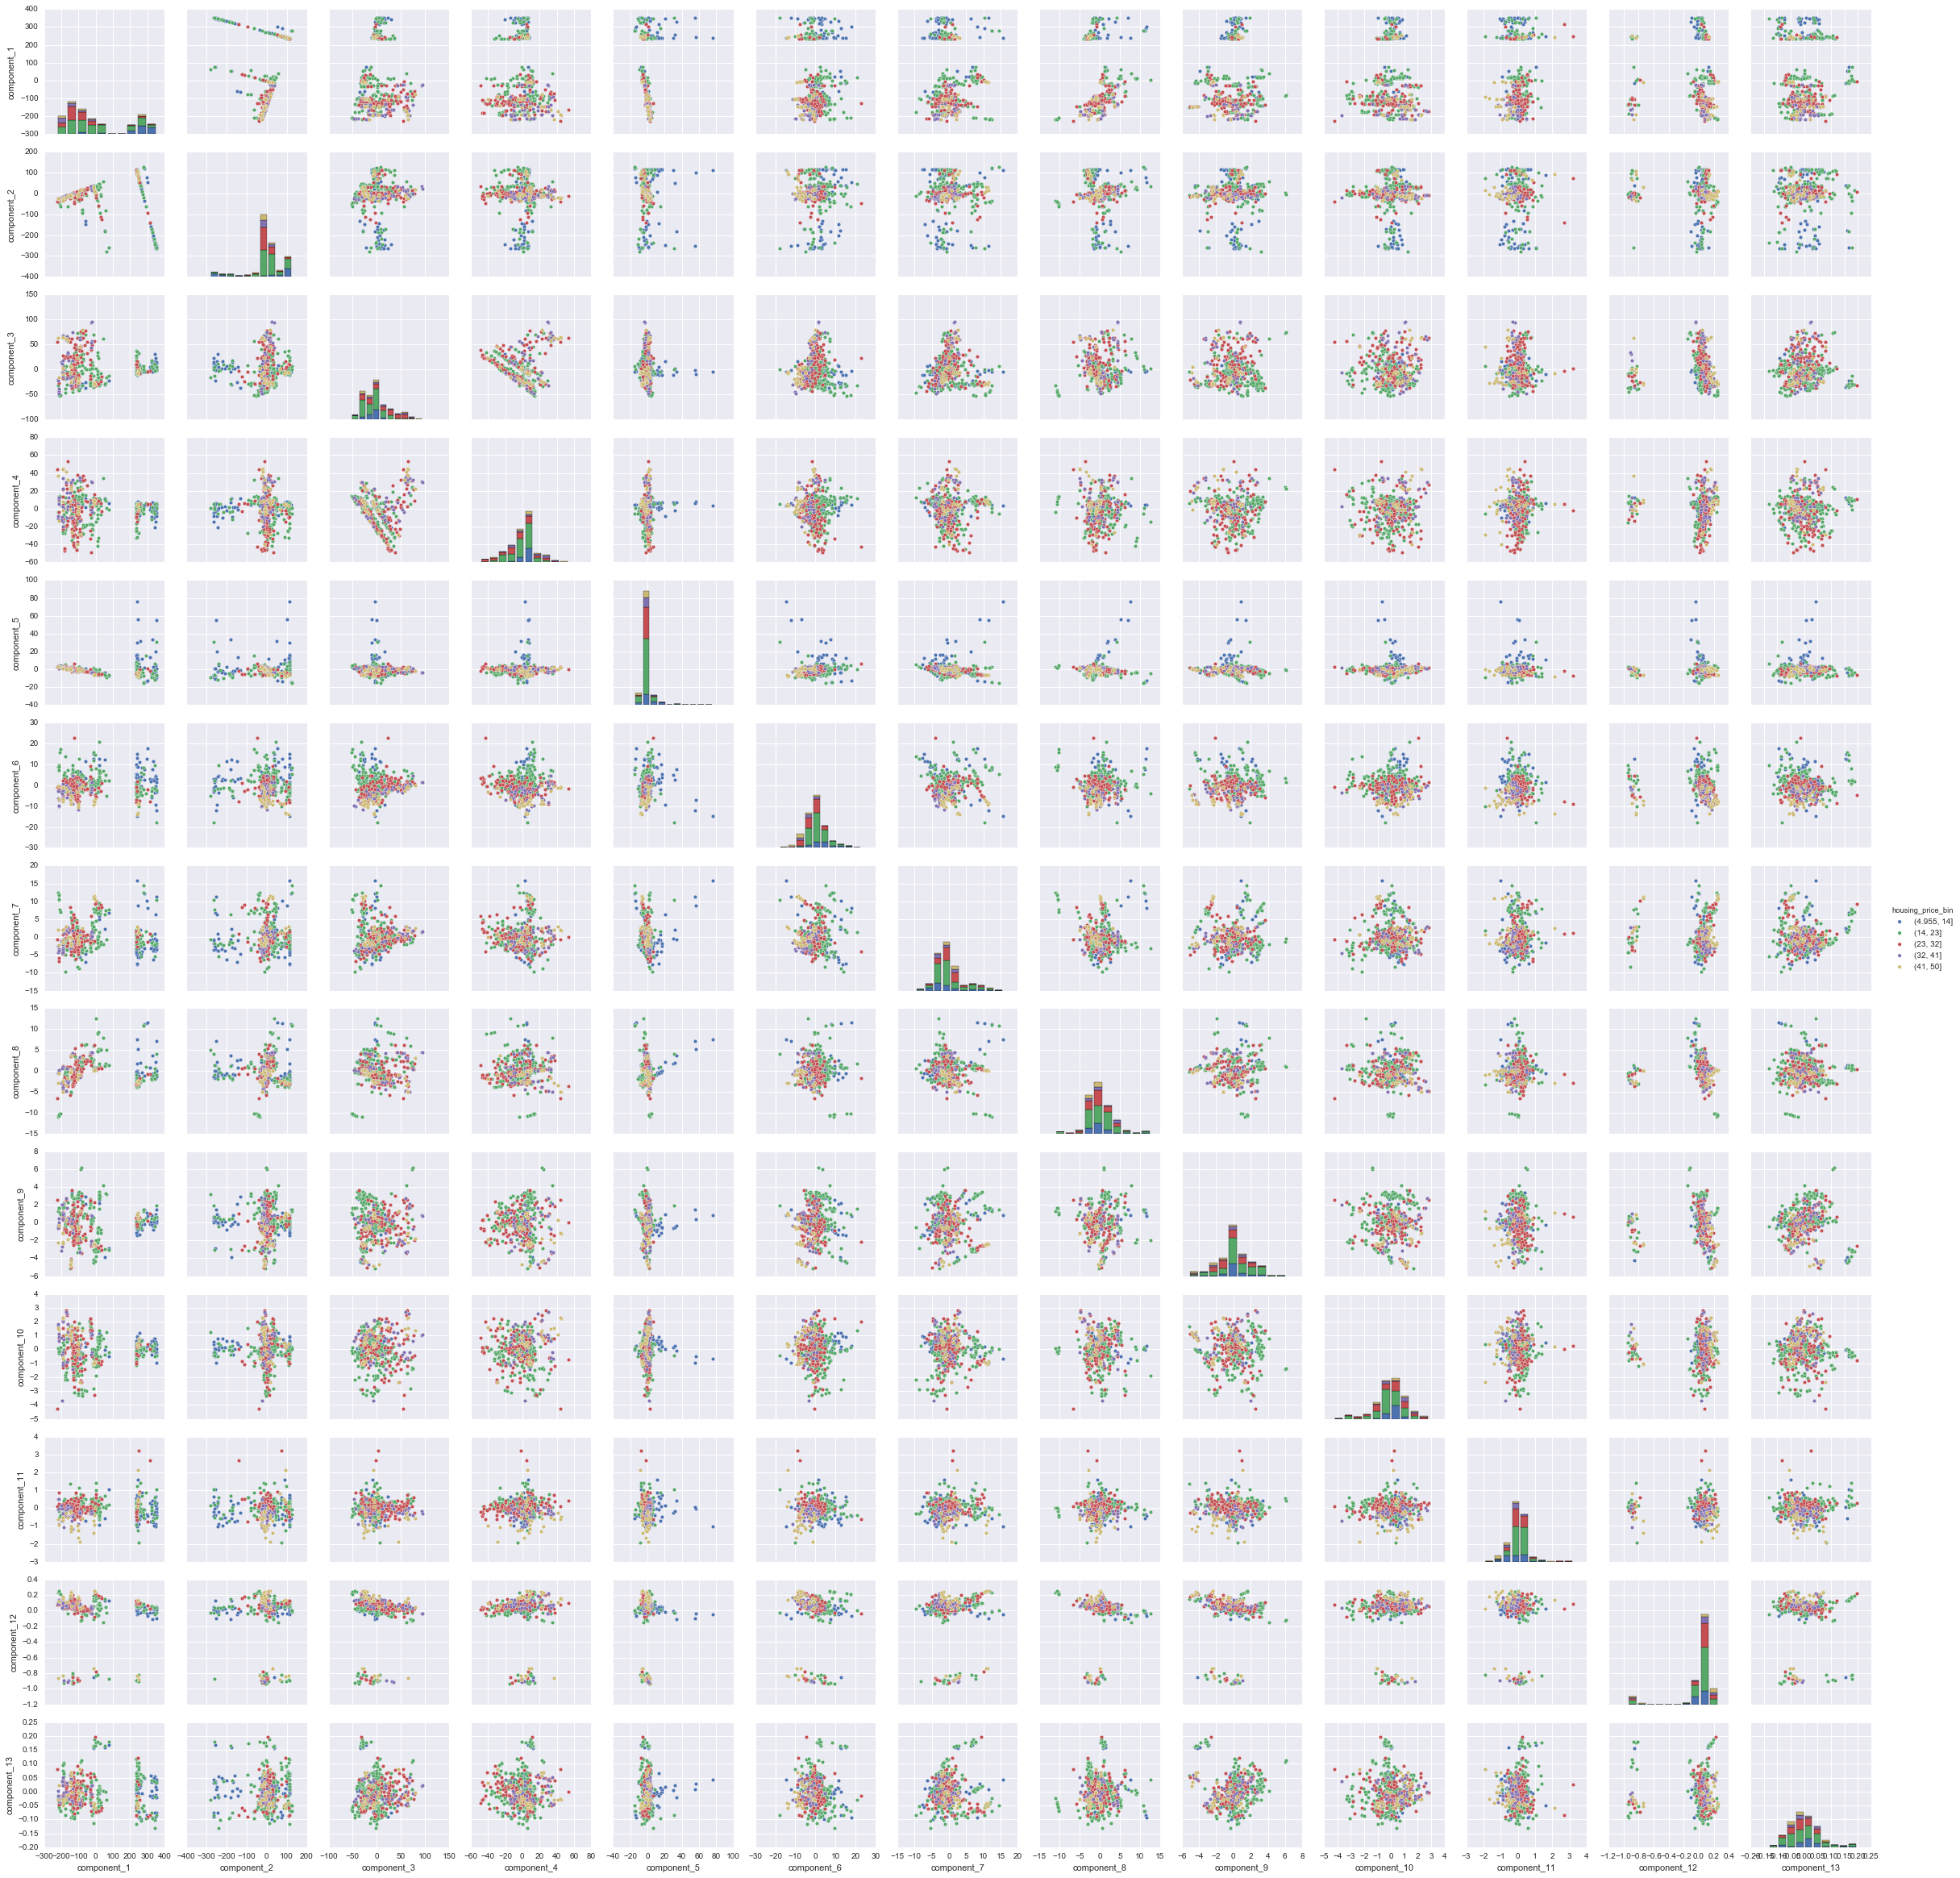

In [15]:
transformed_pca_x["housing_price_bin"] = pd.cut(housing_data[housing_target],5)
sns.pairplot(transformed_pca_x,hue="housing_price_bin")

So this doesn't look like it helps very well in this case. Nonetheless, PCA is a useful technique in some cases. 

Specifically, it **can be very very useful when you have hundreds and hundreds of columns and need to drastically reduce the total number of columns you are working with to reduce how long it takes to build your classification model.**

### Exercise Time

* Perform PCA on the `iris` dataset. Attempt to classify the 3 types of irises from each other using just the first 2 components of a PCA-transformed dataset, and using the full untransformed dataset. What is the classification difference?

In [16]:
iris_data = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/iris/bezdekIris.data",
                        names=["sepal_length","sepal_width","petal_length","petal_width","iris_type"])

iris_columns = ["sepal_length","sepal_width","petal_length","petal_width","iris_type"]
iris_features = iris_columns[:-1]
iris_target = iris_columns[-1]

le = LabelEncoder()
iris_data.iris_type = le.fit_transform(iris_data.iris_type)
print(iris_data.describe())
print(iris_features)
print(iris_target)
iris_data.head()

       sepal_length  sepal_width  petal_length  petal_width   iris_type
count    150.000000   150.000000    150.000000   150.000000  150.000000
mean       5.843333     3.057333      3.758000     1.199333    1.000000
std        0.828066     0.435866      1.765298     0.762238    0.819232
min        4.300000     2.000000      1.000000     0.100000    0.000000
25%        5.100000     2.800000      1.600000     0.300000    0.000000
50%        5.800000     3.000000      4.350000     1.300000    1.000000
75%        6.400000     3.300000      5.100000     1.800000    2.000000
max        7.900000     4.400000      6.900000     2.500000    2.000000
['sepal_length', 'sepal_width', 'petal_length', 'petal_width']
iris_type


,sepal_length,sepal_width,petal_length,petal_width,iris_type
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


,sepal_length,sepal_width,petal_length,petal_width,iris_type
sepal_length,1.000000,-0.117570,0.871754,0.817941,0.782561
sepal_width,-0.117570,1.000000,-0.428440,-0.366126,-0.426658
petal_length,0.871754,-0.428440,1.000000,0.962865,0.949035
petal_width,0.817941,-0.366126,0.962865,1.000000,0.956547
iris_type,0.782561,-0.426658,0.949035,0.956547,1.000000


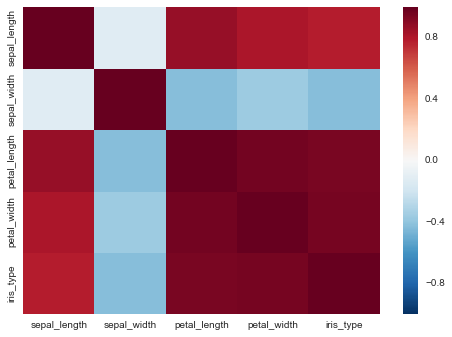

In [17]:
sns.heatmap(iris_data.corr())
iris_data.corr()

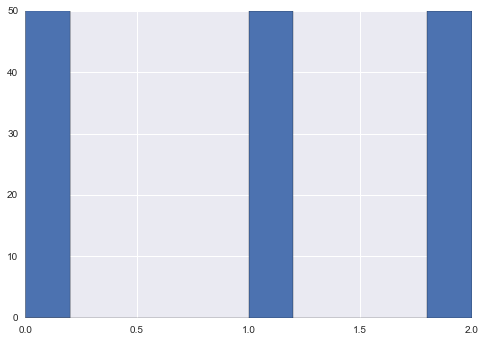

In [18]:
iris_data[iris_target].hist(bins=10)
# target feature: iris_type
# The x axis of the histogram is the iris_type;

In [19]:
#standardize the features, to get actual interpretable coefficients for each feature
X = StandardScaler().fit_transform(iris_data[iris_features])
y = iris_data[iris_target]

lr = LinearRegression()

#must take absolute value because sklearn makes the errors negative - dont ask me why
mean_squared_errors = np.abs(cross_val_score(lr,X,y,cv=50,scoring='mean_squared_error'))
root_mean_squared_errors = np.sqrt(mean_squared_errors)
print(mean_squared_errors)
print(root_mean_squared_errors)
print("50-fold mean RMSE: ", np.mean(root_mean_squared_errors))

[ 0.00401094  0.00308392  0.00130133  0.00619711  0.02697999  0.00142026
  0.00116315  0.0166307   0.00534619  0.00484095  0.00958173  0.01358055
  0.01416121  0.00334787  0.02479312  0.00128781  0.01866692  0.07877543
  0.1137177   0.0331849   0.02828891  0.04612828  0.09402227  0.12702029
  0.08389202  0.13012818  0.04664401  0.10709255  0.14830886  0.03483113
  0.04803866  0.02295947  0.02550521  0.05065252  0.0273247   0.07595626
  0.05586872  0.04938392  0.0344843   0.10857432  0.01696521  0.09237414
  0.12361253  0.1165297   0.21299151  0.03389926  0.07322113  0.03025625
  0.04541517  0.06262094]
[ 0.06333197  0.05553304  0.03607396  0.07872174  0.16425588  0.03768632
  0.03410492  0.12896007  0.07311762  0.06957694  0.09788631  0.11653561
  0.11900087  0.05786074  0.15745831  0.03588602  0.13662692  0.28066961
  0.33722055  0.18216724  0.16819306  0.21477496  0.30663051  0.35639906
  0.28964119  0.36073284  0.21597225  0.32724998  0.38510889  0.18663099
  0.21917724  0.15152383 

In [20]:
coeffs = LinearRegression().fit(X,y).coef_
coeff_df = pd.DataFrame(list(zip(iris_features,np.abs(coeffs))),columns=["features","betas"])
coeff_df.sort_values("betas",ascending=False,inplace=True)
print(coeffs)
coeff_df

[-0.09235605 -0.01741097  0.40227899  0.46284429]


,features,betas
3,petal_width,0.462844
2,petal_length,0.402279
0,sepal_length,0.092356
1,sepal_width,0.017411


In [21]:
pca = PCA()
transformed_pca_x = pca.fit_transform(iris_data[iris_features])
#create component indices
component_names = ["component_"+str(comp) for comp in range(1, len(pca.explained_variance_)+1)]

#generate new component dataframe
transformed_pca_x = pd.DataFrame(transformed_pca_x,columns=component_names)
print(iris_data[iris_features].head())
print(component_names)
print(pca.explained_variance_)
transformed_pca_x.head()

   sepal_length  sepal_width  petal_length  petal_width
0           5.1          3.5           1.4          0.2
1           4.9          3.0           1.4          0.2
2           4.7          3.2           1.3          0.2
3           4.6          3.1           1.5          0.2
4           5.0          3.6           1.4          0.2
['component_1', 'component_2', 'component_3', 'component_4']
[ 4.20005343  0.24105294  0.0776881   0.02367619]


,component_1,component_2,component_3,component_4
0,-2.684126,-0.319397,0.027915,0.002262
1,-2.714142,0.177001,0.210464,0.099027
2,-2.888991,0.144949,-0.017900,0.019968
3,-2.745343,0.318299,-0.031559,-0.075576
4,-2.728717,-0.326755,-0.090079,-0.061259


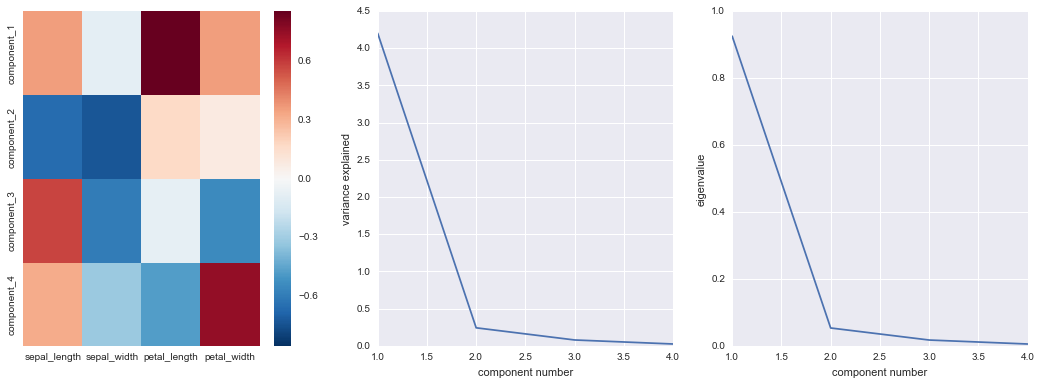

In [22]:
#generate component loadings on original features
component_matrix = pd.DataFrame(pca.components_,index=component_names,columns = iris_features)
#add additional columns to describe what
component_matrix["explained_variance_ratio"] = pca.explained_variance_ratio_
component_matrix["eigenvalue"] = pca.explained_variance_
figure = sns.plt.figure(figsize=(18,6))
#add 3 subplots one at a time

#first the component matrix
figure.add_subplot(131)
sns.heatmap(component_matrix.ix[:,:-2])

#then the eigenvalues
figure.add_subplot(132)
sns.plt.plot(range(1,component_matrix.shape[0]+1), component_matrix.eigenvalue)
sns.plt.xlabel("component number")
sns.plt.ylabel("variance explained")

#then the explained variance ratio
figure.add_subplot(133)
sns.plt.plot(range(1,component_matrix.shape[0]+1), component_matrix.explained_variance_ratio)
sns.plt.xlabel("component number")
sns.plt.ylabel("eigenvalue")

In [23]:
component_matrix.explained_variance_ratio.cumsum()

component_1    0.924619
component_2    0.977685
component_3    0.994788
component_4    1.000000
Name: explained_variance_ratio, dtype: float64

In [24]:
mean_squared_errors = np.abs(cross_val_score(lr,transformed_pca_x.ix[:,:2],y,cv=50,scoring='mean_squared_error'))
#apply square root to each fold
root_mean_squared_errors = np.sqrt(mean_squared_errors)
print("50-fold mean RMSE: ", np.mean(root_mean_squared_errors))
print("50-fold std RMSE: ", np.std(root_mean_squared_errors))
#Recall that we intially/originally had:   50-fold mean RMSE:  0.198496413666

50-fold mean RMSE:  0.224355569787
50-fold std RMSE:  0.118687382258


In [25]:
# How many components do we need to keep to achieve a very similar performance? I think we need to keep 3 components..
lr = LinearRegression()
transformed_pca_x["iris_type_bin"] = pd.cut(iris_data[iris_target],5)
X=transformed_pca_x.iloc[:, :3]   #  we need to keep 4 components to achieve similar performance to
                                   # to what we had originally
mean_squared_errors = np.abs(cross_val_score(lr,X,y,cv=50,scoring='mean_squared_error'))
#apply square root to each fold
root_mean_squared_errors = np.sqrt(mean_squared_errors)
print("50-fold mean RMSE: ", np.mean(root_mean_squared_errors))
print("50-fold std RMSE: ", np.std(root_mean_squared_errors))

50-fold mean RMSE:  0.202867476191
50-fold std RMSE:  0.105307131277


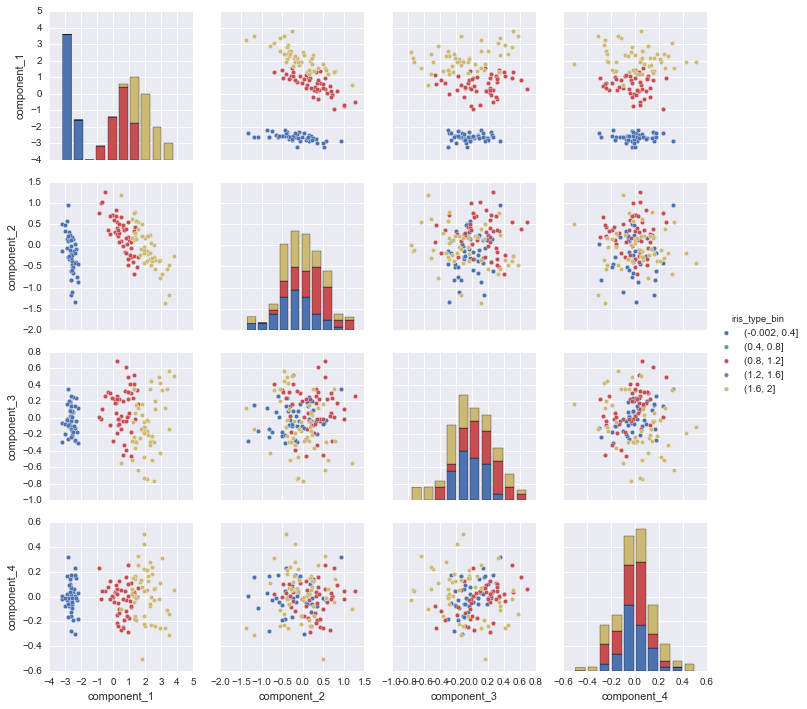

In [26]:
transformed_pca_x["iris_type_bin"] = pd.cut(iris_data[iris_target],5)
sns.pairplot(transformed_pca_x,hue="iris_type_bin")

Now, let's try something else with the Boston dataset in order to improve the overall predictive accuracy.

Let's generate additional polynomial features up to degree 2 (all pairwise interactions among our original columns), and see if we can't improve the overall RMSE (by adding non-linearities that might be predictive apart from the linear features we've had so far):

In [27]:
#generate the transformer
pf_2 = PolynomialFeatures(degree=2,interaction_only=True)
#apply it to the data, but ignore the first constant column
pf_2_data = pf_2.fit_transform(housing_data[housing_features])[:,1:] #ignore first constant column
print(pf_2_data.shape)
lr = LinearRegression()
#get the mean squared errors per fold, 10 fold cv
absolute_errors = np.abs(cross_val_score(lr,pf_2_data,housing_data[housing_target],cv=10))
#convert each fold's mean squared errors to rmse
rmses = np.sqrt(absolute_errors)
print("10-fold mean RMSE for degree-2 case: ",np.mean(rmses))

(506, 91)
10-fold mean RMSE for degree-2 case:  0.959271302854


So that worked really well, we generated all interaction features, along with our original features, and now we have much lower RMSE! Awesome!

What if we extended this to 3-degree polynomials?

In [28]:
#generate the polynomial transformer
pf_3 = PolynomialFeatures(degree=3,interaction_only=True)
#apply it to the data, but ignore the first constant column
pf_3_data = pf_3.fit_transform(housing_data[housing_features])[:,1:]#ignore constant column
print(pf_3_data.shape)
lr = LinearRegression()
mean_squared_errors_poly3 = np.abs(cross_val_score(lr,pf_3_data,housing_data[housing_target],cv=10))
rmses_poly3 = np.sqrt(mean_squared_errors_poly3)
print("10-fold mean RMSE for degree-3 case: ",np.mean(rmses_poly3))
# We get a high error here
# lr.fit(pf_3_data)
# lr.coef_

(506, 377)
10-fold mean RMSE for degree-3 case:  14.9651472565


Why did this get so much worse?

We have officially horribly overfit our data. Is there anything that can be done in this case?

**YES. We can apply what is called REGULARIZATION!**

Regularization is a method for penalizing overly complicated models, while minimizing out-of-sample (test-set) error. We will talk about 2 kinds of regularization, which have different names, depending on whether they are being used for regression or classification:

 * **Lasso/L1 Regularization**
 * **Ridge/L2 Regularization**

In essence, regularization is a method for adding additional constraints or penalties to a model, with the goal of preventing overfitting and improving generalization.

### Lasso Regression / L1 Regularization for Logistic Regression

In traditional regression/classification, we try to minimize some kind of loss function (we try to make the loss be as close to 0 as possible). In regression, this is usually the **mean squared error** (or root mean squared error). However, with regularization, instead of just minimizing the loss based on the error of the model, we can also add a term that effectively "punishes" more complicated models.

What this means is that as you add more terms (features/columns) to your model, you suffer more added "loss due to complexity" in addition to "loss due to model performance." 

So, how can regularization be used in linear regression to effectively make models simpler?

**You reduce the coefficients for specific columns in your model until they go to zero (or very close to zero) for your model, which has the net effect of not using those features (or using them very sparingly)**

More mathematically, Lasso/L1 regularization adds an absolute-value penalty to the loss function:

$$loss_{lasso} = |Xw-Y|^2 + \lambda|w|$$

Whereas the non-regularized version is simply:

$$loss = |Xw-Y|^2$$

So, L1 regularization adds a penalty (based on $\lambda$) to the regular loss function. Since each non-zero coefficient adds to the penalty, it forces weak features to have zero as coefficients. Thus L1 regularization produces sparse solutions, inherently performing feature selection.

However, because this is an absolute value-based regularization (and absolute values are no-fun when it comes to taking derivatives), L1/Lasso regularization can lead to non-unique solutions (especially when you have highly correlated features...why?).

For regression, Scikit-learn offers the `Lasso` and `LassoCV` functions, and for Logistic regression it offers the `l1` penalty parameter for classification. Let's use the `Lasso` with full regularization (when $\lambda=0$) on the degree-3 case:

In [29]:
lasso = Lasso(max_iter=2000) #increase the number of iterations for lasso to prevent lack of convergence
mean_squared_errors_poly3_lasso = np.abs(cross_val_score(lasso,pf_3_data,housing_data[housing_target],cv=10))
rmses_lasso_poly3 = np.sqrt(mean_squared_errors_poly3_lasso)
print("10-fold mean RMSE for degree-3 case, strongest lasso regularization: ",np.mean(rmses_lasso_poly3))
# Compare to what we had previously -- 10-fold mean RMSE for degree-3 case:  14.9651472565

/Users/markyashar/anaconda/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


10-fold mean RMSE for degree-3 case, strongest lasso regularization:  0.871966016477


In [30]:
print(lasso.coef_)

None


Wow! That worked very well! We now have a much better model! Let's examine how many of the coefficients are non-zero when we fit on the full dataset:

In [31]:
lasso_all = Lasso().fit(pf_3_data,housing_data[housing_target])
print("Number of features in the model: ",len(lasso_all.coef_))
non_zero_features_mask = np.abs(lasso_all.coef_)>0.0001
print(non_zero_features_mask)
# We examine how many of the coefficients are non-zero when we fit on the full dataset.
print("Number of non-zero features in the model: ",np.sum(non_zero_features_mask.astype(int)))
print("Fraction of total features used: ",float(np.sum(non_zero_features_mask.astype(int)))/len(lasso_all.coef_))

Number of features in the model:  377
[False False False False False False False False False False False False
 False False False False False False  True False False  True False  True
 False False False False False False  True False  True False  True False
 False False False  True False False  True False  True False False False
 False False False False False False False False False False False  True
 False False False  True False False  True False  True False False  True
  True  True  True  True False  True False  True False  True False  True
 False  True False  True  True False  True False False False False  True
 False False  True False  True False False False  True  True False  True
 False  True False False False False False False False  True False  True
 False False  True False False  True False  True False  True False  True
 False  True  True  True  True False False False False  True False  True
 False  True  True False False False  True False False False False  True
 False False 

So, with full lasso regularization, we get a model that uses less than 40% of the original columns, and performs better than the model that only uses the original features or the combination of the original features and the pairwise interactions!

#### Exercise Time!

 * Try the lasso method but generating the 4th order polynomial features (use `PolynomialFeatures(degree=4,interactions_only=True)` and the same `Lasso()` and `cross_val_score` functions). Does our RMSE improve yet again?
 * Try the lasso method for the poly3 case, but change the $\lambda$ (called $\alpha$ in sklearn) parameter to `0.2`; What happens to the RMSE? What happens to the fraction of non-zero features in the model trained on all the data?

In [42]:
#pass -- i think
#generate the polynomial transformer
pf_4 = PolynomialFeatures(degree=4,interaction_only=True)
#apply it to the data, but ignore the first constant column
pf_4_data = pf_4.fit_transform(housing_data[housing_features])[:,1:]#ignore constant column
print(pf_4_data.shape)
lr = LinearRegression()
mean_squared_errors_poly4 = np.abs(cross_val_score(lr,pf_4_data,housing_data[housing_target],cv=10))
rmses_poly4 = np.sqrt(mean_squared_errors_poly4)
print("10-fold mean RMSE for degree-4 case: ",np.mean(rmses_poly4))
# We get a much higher error here
# lr.fit(pf_3_data,housing)

(506, 1092)
10-fold mean RMSE for degree-4 case:  866.961898999


In [44]:
#generate the polynomial transformer
pf_4 = PolynomialFeatures(degree=4,interaction_only=True)
#apply it to the data, but ignore the first constant column
pf_4_data = pf_4.fit_transform(housing_data[housing_features])[:,1:]#ignore constant column
print(pf_4_data.shape)


lasso = Lasso(max_iter=2000)#increase the number of iterations for lasso to prevent lack of convergence
mean_squared_errors_poly4_lasso = np.abs(cross_val_score(lasso,pf_4_data,housing_data[housing_target],cv=10))
rmses_lasso_poly4 = np.sqrt(mean_squared_errors_poly4_lasso)
print("10-fold mean RMSE for degree-4 case, strongest lasso regularization: ",np.mean(rmses_lasso_poly4))


(506, 1092)
10-fold mean RMSE for degree-4 case, strongest lasso regularization:  1.06847099638


In [55]:
scores = []
alphas = [0.1, 0.2, 0.5, 1, 2, 5]
for alpha in alphas:
    lasso = Lasso(alpha=alpha, max_iter=2000)#increase the number of iterations for lasso to prevent lack of convergence
    lasso_all = Lasso(alpha=alpha, max_iter=2000).fit(pf_3_data,housing_data[housing_target])
    mean_squared_errors_poly3_lasso = np.abs(cross_val_score(lasso,pf_3_data,housing_data[housing_target],cv=10))
    rmses_lasso_poly3 = np.sqrt(mean_squared_errors_poly3_lasso)
    scores.append(np.mean(rmses_lasso_poly3))
    print("Number of features in the model: ",len(lasso_all.coef_))
non_zero_features_mask = np.abs(lasso_all.coef_)>0.0001
print(non_zero_features_mask)
# We examine how many of the coefficients are non-zero when we fit on the full dataset.
print("Number of non-zero features in the model: ",np.sum(non_zero_features_mask.astype(int)))
print("Fraction of total features used: ",float(np.sum(non_zero_features_mask.astype(int)))/len(lasso_all.coef_))
# In this case, we get:
# Number of non-zero features in the model:  93
# Fraction of total features used:  0.246684350133
# So, the fraction of non-zero features in the model trained on all the data goes down.

Number of features in the model:  377
Number of features in the model:  377
Number of features in the model:  377
Number of features in the model:  377
Number of features in the model:  377
Number of features in the model:  377
[False False False False False False False False False False False False
 False False False False False False False False False  True False False
 False False False False False False False False  True False  True False
 False False False False False False  True False  True False False False
 False False False False False False False False False False False False
 False False False False False False False False  True False False False
  True False  True False False False False  True False  True False False
 False False  True  True  True False  True False False False False False
 False False  True False  True False False False  True  True False  True
 False False False False False False False False False  True False False
 False False False False False  True False

In [52]:
print(scores)

[0.97087005524234959, 0.92826092254700554, 0.89221652910932669, 0.87196601647732896, 0.82791554782875088, 0.72744981026664746]


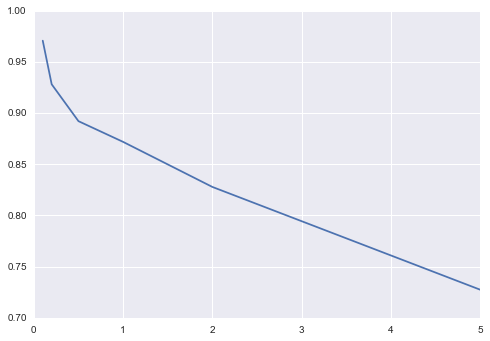

In [36]:
plt.plot(alphas, scores)

### Ridge Regression / L2 Regularization for Logistic Regression

So, Lasso looks really excellent to use a regularization method. However, as I'd mentioned before, it is difficult to use across the board for all regression/classification problems, because it can create non-unique solutions, or solutions don't always converge (because of the problem with taking derivatives of a function that is not differentiable everywhere).

So, what can be done? We can create a penalty term that is smooth and therefore differentiable everywhere. Specifically, we can use what is called **Ridge/L2 regularization.** Here, the loss is slightly different:

$$loss_{ridge} = |Xw-Y|^2 + \lambda|w|^2$$

The act of squaring the weight features makes the penalty differentiable (because the values now smoothly transition to 0). So, squaring the L1 penalty turns it into an L2 penalty Square the Lasso and get a Ridge (or something).

Since the coefficients are squared in the penalty expression, it has a different effect from L1-norm, namely it forces the coefficient values to be spread out more equally. For correlated features, it means that they tend to get similar coefficients (whereas in L1 regularization, one of the terms will be forced to 0).

**The effect of this is that models are much more stable (coefficients do not fluctuate on small data changes as is the case with unregularized or L1 models). So while Ridge/L2 regularization does not perform feature selection the same way as L1 does, it is much more useful for feature *interpretation*; a predictive feature will get a non-zero coefficient, which is often not the case with L1.**

Let's use the full-penalty Ridge regression and see what happens:

In [37]:
ridge = Ridge()
ridge_cv_squared_errors = np.abs(cross_val_score(ridge,pf_3_data,housing_data[housing_target],cv=10))
rmse_ridge_cv = np.sqrt(ridge_cv_squared_errors)
print("10-fold mean RMSE for degree-3 case, strongest lasso regularization: ",np.mean(rmse_ridge_cv))

10-fold mean RMSE for degree-3 case, strongest lasso regularization:  5.25152234185


#### Exercise Time

* Try to use both lasso and ridge on the degree-2 polynomial version of the data, do either of them reduce the RMSE? What does our result tell us about the full degree-2 model?

In [38]:
ridge_2 = Ridge()
ridge_cv_squared_errors_2 = np.abs(cross_val_score(ridge_2,pf_2_data,housing_data[housing_target],cv=10))
rmse_ridge_cv_2 = np.sqrt(ridge_cv_squared_errors_2)
print("10-fold mean RMSE for degree-2 case, strongest lasso regularization: ",np.mean(rmse_ridge_cv_2))

10-fold mean RMSE for degree-2 case, strongest lasso regularization:  1.05206687652


In [39]:
scores = []
alphas = [0.1, 0.2, 0.5, 1, 2, 5]
for alpha in alphas:
    lasso = Lasso(alpha=alpha, max_iter=2000)#increase the number of iterations for lasso to prevent lack of convergence
    mean_squared_errors_poly2_lasso = np.abs(cross_val_score(lasso,pf_2_data,housing_data[housing_target],cv=10))
    rmses_lasso_poly2 = np.sqrt(mean_squared_errors_poly2_lasso)
    scores.append(np.mean(rmses_lasso_poly2))
print(scores)
# For alpha=5, we have a 10-fold RMSE for degree-2 case of 1.03026

[1.3263024528290779, 1.3379113688864084, 1.2719579601061479, 1.1892508501488206, 1.0685488309111117, 1.0302634633540819]


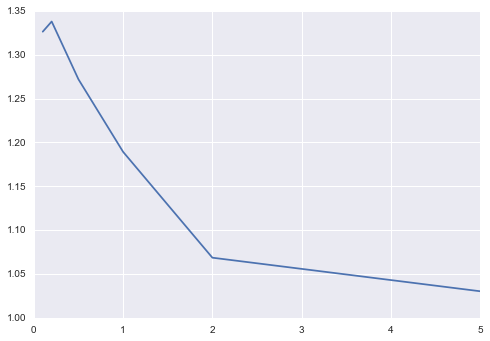

In [40]:
plt.plot(alphas, scores)

In [41]:
#generate the polynomial transformer
pf_2 = PolynomialFeatures(degree=2,interaction_only=True)
#apply it to the data, but ignore the first constant column
pf_2_data = pf_2.fit_transform(housing_data[housing_features])[:,1:]#ignore constant column
print(pf_2_data.shape)

lasso = Lasso(max_iter=2000)#increase the number of iterations for lasso to prevent lack of convergence
mean_squared_errors_poly2_lasso = np.abs(cross_val_score(lasso,pf_2_data,housing_data[housing_target],cv=10))
rmses_lasso_poly2 = np.sqrt(mean_squared_errors_poly2_lasso)
print("10-fold mean RMSE for degree-2 case, strongest lasso regularization: ",np.mean(rmses_lasso_poly2))

(506, 91)
10-fold mean RMSE for degree-2 case, strongest lasso regularization:  1.18925085015


### Lasso vs. Ridge

#### Lasso:
* produces sparse models 
* is useful for strong feature selection in order to improve model performance, or to minimize the number of explanatory variables.
* can produce non-unique solutions (when some features are very strongly correlated)
* can produce very different solutions depending on slight changes in features (because of non-uniqueness)

#### Ridge:
* produces stable models with smooth non-zero coefficients across features. 
* is useful for data interpretation, understanding what features, even when correlated, may be used in combination to predict the response.
* may tell you something about how the data itself was generated.

You can combine both Lasso and Ridge models into a single penalized model (that uses a weighted combination of Lasso and Ridge regression). This is called the `ElasticNet`.

### General Strategy and Takeaways

* PCA is more useful for explanation/data exploration than it is for classification/regression when you have few (< 100) features.
* When generating polynomial features, generate the lowest-order polynomial interactions first, drop the constant term (the first column in the matrix), and try to use the full model for regression/classification.
* If you are trying for data explanation, use Ridge/L2 regularization
* If you are going for sparse models, use Lasso/L1, but realize that the solution may be non-unique. In general, Lasso doesn't always perform better than Ridge.
* `ElasticNet` requires significantly more tuning than either method, but can lead to the highest performing "linear" models. **As always, with great power comes great responsibility, so use all of these methods wisely.**